In [49]:
from imprint.nb_util import setup_nb
setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imprint as ip
import imprint.bound.normal as normal
from imprint.models.ztest import ZTest1D
from imprint.models.ttest_adaptive import TTest1DAda

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
mu_0 = 0  # fixed threshold for null hypothesis
theta_min = [0, -0.5]  # minimum for theta
theta_max = [0, -0.5]  # maximum for theta
n_init = 10  # initial number of Gaussian draws
n_samples_per_interim = 10  # number of Gaussian draws per interim
n_interims = 5  # number of interims
n_gridpts = [1, 1]  # number of grid-points along each direction
alpha = 0.025  # target nominal level
n_sims = 100000  # number of simulations
eff_size_thresh = 0.1

In [60]:
grid = ip.cartesian_grid(
    theta_min=theta_min,
    theta_max=theta_max,
    n=n_gridpts,
    null_hypos=[ip.hypo("x <= 0")],
)

model = TTest1DAda(
    seed=0,
    max_K=n_sims,
    n_init=n_init,
    n_samples_per_interim=n_samples_per_interim,
    n_interims=n_interims,
    mu0=mu_0,
    eff_size_thresh=eff_size_thresh,
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1675702768, n_bits=18, worker_bits=18) = [4472952939769757696, ...]:


In [61]:
Ts = -model.sim_batch(0, n_sims, grid.get_theta(), grid.get_null_truth())[0]
Ts_pruned = Ts[~jnp.isinf(Ts)]

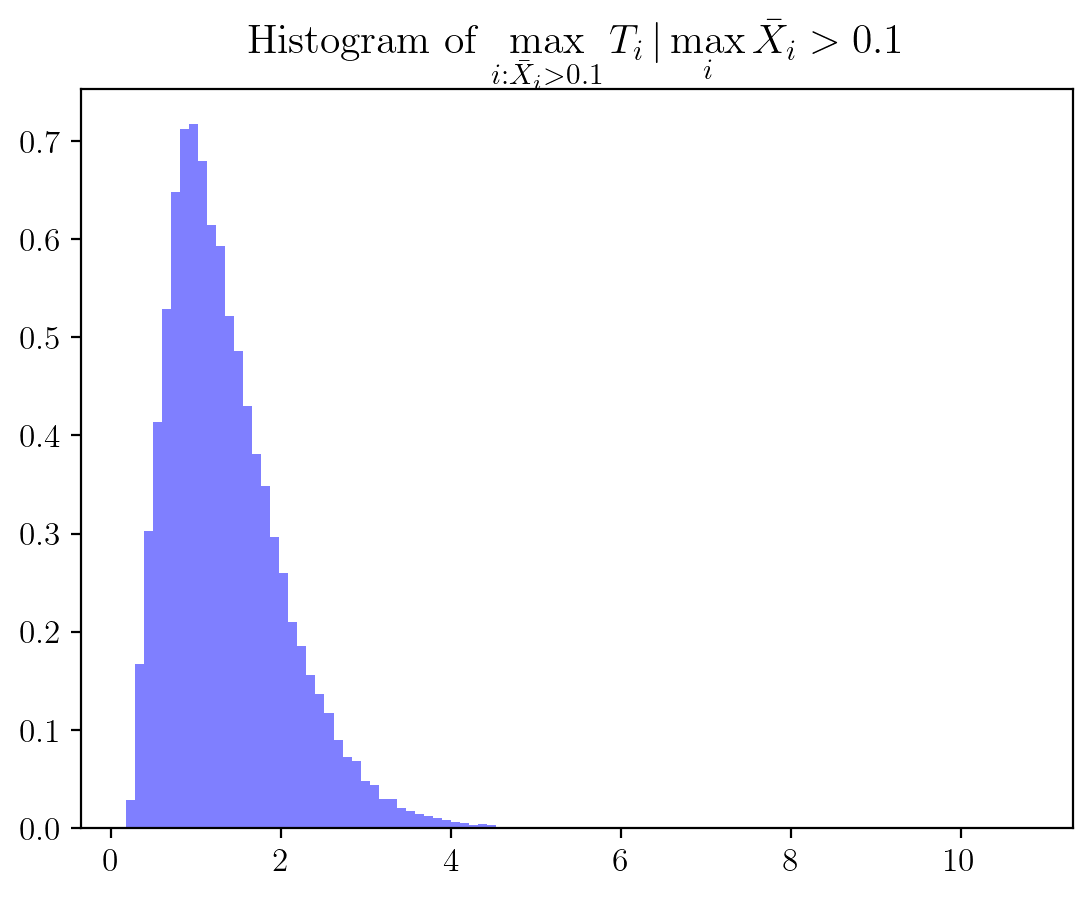

In [64]:
plt.hist(Ts_pruned, density=True, bins=100, color='blue', alpha=0.5)
plt.title(f"Histogram of $\max\limits_{{i: \\bar{{X}}_i > {eff_size_thresh}}} T_i \, | \max\limits_{{i}} \\bar{{X}}_i > {eff_size_thresh}$")
plt.savefig("figures/introduction_att_hist.pdf", bbox_inches='tight')
plt.show()